In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
import os
import time
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [2]:
stemmer = WordNetLemmatizer()

In [3]:
''' "extract_frequency_wise" function is used to extract the words along with there
    frequency from the single data file
    after removing all special characters, spaces, stopwords and every useless
    chars
    
    Parameters
    ----------
    data: file from which to be extracted
    
    Returns
    -------
    vocab_dict: dicitionary of words with frequency
'''

def extract_frequency_wise(data):
    documents = []
    
    ''' Removing Remove all the special characters, all single character,
        starting with single character,
        multiple spaces
        with only one single space
    '''
    
    for x in range(0, len(data)):  
        document = re.sub(r'\W', ' ', str(data[x]))
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        document = re.sub(r'^[a-zA-Z]\s+', ' ', document) 
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        document = document.lower()
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        documents.append(document)
        
    ''' Removing stopwords and numbers '''
    
    vocab = []
    stop_words = stopwords.words('english')
    
    for i in range(len(documents)):
        for j in range(len(documents[i])):
            if not documents[i][j].isdigit() and documents[i][j] not in stop_words:
                vocab.append(documents[i][j])
    
    ''' creating frequency list '''
    
    vocab_dict = {}
    for w in vocab:
        if w not in vocab_dict:
            vocab_dict[w] = 1
        else:
            vocab_dict[w] += 1
    
    return vocab_dict

In [4]:
''' "load_20news_group" function is used to load the '20 news group' data into
    python dictionary after removing special characters from each files with help of
    "extract_frequency_wise" function 
    it stores the data into dictionary with folder name (or 20 news group classes) as a "keys"
    and list of dictionary(of vocabulary) of each file from particular folder as "values"
    
    Parameters
    ----------
    data_per_group: integer, size of data(or files) to be load from each folder
    
    Results
    -------
    dictionary: dictionary of folder wise files vocabulary
'''

def load_20news_group(data_per_group = None):
    dictionary = {}
    path = os.getcwd() + '\\20_newsgroups' # folder path
    
    
    ''' Getting Folders Names '''
    news_groups_name = [] 
    for folder_name in os.listdir(path):
        news_groups_name.append(folder_name) # appending folders name

        
    ''' Getting Files Names From Each Folder'''
    files_name_dict = {}
    for folder_name in news_groups_name:
        files_name_dict[folder_name] = os.listdir(path + '\\' + folder_name) #appending file names group by folders

        
    ''' creating frequency dictionary of words '''
    for news_group in news_groups_name:
        if data_per_group == None:
            train_limit = len(files_name_dict[news_group])
        else:
            train_limit = data_per_group
        dictionary[news_group] = []
        for file_name in files_name_dict[news_group]:
            if train_limit:
                f = open(path + '\\' + news_group +'\\'+ file_name)
                file_stream = f.readlines()
                vocab = extract_frequency_wise(file_stream) # extracting words
                dictionary[news_group].append(vocab)
                f.close()
            else:
                break
                
            train_limit -= 1
            
    return dictionary

In [5]:
''' "divide_data_train_test" function is used to divide to loaded data with help of function
    "load_20news_group" into train and test data to further making the single vocabulary list
    of train data to select the features
    
    Parameters
    ----------
    data: dictionary 
    test_size: integer, size of test data
    
    Returns
    -------
    train_data: train_data dictionary
    test_data: test_data dictionary
'''

def divide_data_train_test(data, test_size = 0.25):
    train_data = {}
    test_data = {}
    
    for k in data:
        test_len = int(len(data[k]) * (1-test_size))
        train_data[k] = data[k][:test_len]
        test_data[k]  = data[k][test_len:]
        
    return train_data, test_data

In [6]:
''' "create_vocab_dict_from_train_data" function is used to make a single flat dictionary 
    from the train data for selecting features
    
    Parameters
    ----------
    train_data: dictionary
    
    Returns
    -------
    dictionary
'''
def create_vocab_dict_from_train_data(train_data):
    main_vocab = {}
    for news_grp in train_data:
        for _dict in train_data[news_grp]:
            for k in _dict:
                if k not in main_vocab:
                    main_vocab[k] = _dict[k]
                else:
                    main_vocab[k] += _dict[k]
    return dict(sorted(main_vocab.items(), key = lambda x : x[1], reverse=True))

In [7]:
''' "create_2d_array" function is used to making a 2d numpy array from the non-flat dictionary(or nested dict)
    
    Parameters
    ----------
    data: dictionary
    table_cols: selected features(or words)
    
    Returns
    -------
    2d np array
'''
def create_2d_array(data, table_cols):
    _2darray = []
    for group_name in data.keys():
        for _dict in data[group_name]:
            curr_row = [0] * (len(table_cols) + 1)
            curr_row[-1] = group_name
            for i in range(len(table_cols)):
                if table_cols[i] in _dict:
                    curr_row[i] = _dict[table_cols[i]]
            _2darray.append(curr_row)
    return np.array(_2darray)

# Loading Data from hard drive

In [8]:
start_time = time.time()
data = load_20news_group()
print("--- %s seconds ---" % (time.time() - start_time))

--- 143.17290210723877 seconds ---


## Getting all 20 classes names

In [9]:
classes_names = list(data.keys())
print('unique classes: ',len(classes_names))
classes_names

unique classes:  20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Dividing Training and Testing Data

In [10]:
train_data, test_data = divide_data_train_test(data)
print(len(train_data[classes_names[0]]), len(test_data[classes_names[0]]))

750 250


## Creating Words Dictionary from training data for Selecting Features

In [11]:
main_vocab = create_vocab_dict_from_train_data(train_data)

In [12]:
df = pd.DataFrame({'words': list(main_vocab.keys()), 'frequency': list(main_vocab.values())})
df = df.head(1500)
table_cols = list(df.words.values)
df.head()

,frequency
count,1500.000000
mean,1507.892667
std,4172.523045
min,352.000000
25%,467.750000
50%,696.000000
75%,1236.250000
max,122900.000000


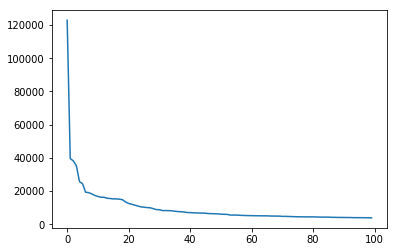

In [13]:
graph = df.head(100)
plt.plot(graph['frequency'])
plt.show()

## Creating 2d array from loaded data and converting into DataFrame

In [14]:
start_time = time.time()
_2darray = create_2d_array(data, table_cols)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.365781307220459 seconds ---


In [15]:
table_cols.append('news_group_class_name')
final_df = pd.DataFrame(_2darray, columns=table_cols)
table_cols.__delitem__(len(table_cols)-1)

In [16]:
final_df.head()

,edu,cmu,com,c,news,srv,cantaloupe,net,wa,line,...,published,wpd,reserve,cross,hallam,psuvm,turned,australia,race,news_group_class_name
0,10,5,1,3,4,3,2,2,1,2,...,0,0,0,0,0,0,0,0,0,alt.atheism
1,5,4,1,3,3,3,2,1,6,1,...,0,0,0,0,0,0,0,0,0,alt.atheism
2,7,3,3,4,2,2,1,1,6,1,...,0,0,0,0,0,0,0,0,0,alt.atheism
3,6,4,1,3,1,3,2,1,1,1,...,0,0,0,0,0,0,0,0,0,alt.atheism
4,4,4,10,3,0,3,2,1,0,1,...,0,0,0,0,0,0,0,0,0,alt.atheism


## Converting String value of classes into integer

In [17]:
class_conv ={}
for i in range(len(classes_names)):
    class_conv[classes_names[i]] = i

In [18]:
for i in range(len(final_df)):
    final_df['news_group_class_name'][i] = class_conv[final_df['news_group_class_name'][i]]

In [19]:
final_df.head()

,edu,cmu,com,c,news,srv,cantaloupe,net,wa,line,...,published,wpd,reserve,cross,hallam,psuvm,turned,australia,race,news_group_class_name
0,10,5,1,3,4,3,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0
1,5,4,1,3,3,3,2,1,6,1,...,0,0,0,0,0,0,0,0,0,0
2,7,3,3,4,2,2,1,1,6,1,...,0,0,0,0,0,0,0,0,0,0
3,6,4,1,3,1,3,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,4,10,3,0,3,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X = np.array(final_df.iloc[:,:-1].values, dtype='int')
Y = final_df['news_group_class_name'].values
Y=Y.astype('int')

## Splitting data into training and testing part using sklearn in built function

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1) 
print(x_train.shape, x_test.shape)

(14997, 1500) (5000, 1500)


## Implementing `Multinomial Naive Bayes` For Text Classification

In [40]:
class MultinomialNaiveBayes:
    
    __map = {}
    __alpha = None
    def fit(self, x_train, y_train, alpha = 1.0):
        self.__alpha = alpha
        for class_type in set(y_train):
            self.__map[class_type] = {}
            xs = x_train[y_train == class_type]
            self.__map[class_type]['total_count'] = xs.sum()
            feature_counts = xs.sum(axis=0)
            for i in range(len(feature_counts)):
                self.__map[class_type][i] = feature_counts[i]
                
                
    def max_probability(self, x_row, classes, feature_len):
        best_class = None
        max_prob = -2**31
        for each_class in  classes:
            temp_prob = 0
            for i in range(feature_len):
                if x_row[i] > 0:
                    temp_prob -= mt.log(self.__map[each_class][i] + self.__alpha) / mt.log(self.__map[each_class]['total_count'] + (self.__alpha * feature_len))
            if temp_prob > max_prob:
                max_prob = temp_prob
                best_class = each_class
        if best_class is not None:
            return best_class
        return -1
            
    
    def predict(self, x_test):
        y_pred = []
        classes = self.__map.keys()
        feature_len = len(x_test[0])
        for x_row in x_test:
            y_pred.append(self.max_probability(x_row, classes, feature_len))
        return np.array(y_pred)


## Classification Using Self Implemented MultinomialNaiveBayes

In [41]:
mnb = MultinomialNaiveBayes()
d = mnb.fit(x_train, y_train)

In [24]:
start_time = time.time()
y_train_pred_me = mnb.predict(x_train)
print("--- %s seconds ---" % (time.time() - start_time))

y_train_pred_me

array([ 0, 15,  0, ...,  5,  0,  0])

In [42]:
start_time = time.time()
y_test_pred_me = mnb.predict(x_test)
print("--- %s seconds ---" % (time.time() - start_time))

y_test_pred_me

--- 180.46233224868774 seconds ---


array([ 8, 15, 15, ..., 15, 15, 15])

In [26]:
print((classification_report(y_train, y_train_pred_me)))

             precision    recall  f1-score   support

          0       0.20      0.90      0.33       739
          1       0.78      0.80      0.79       752
          2       0.96      0.56      0.71       747
          3       0.79      0.85      0.82       740
          4       0.87      0.90      0.89       734
          5       0.88      0.75      0.81       735
          6       0.84      0.91      0.87       748
          7       0.95      0.83      0.89       777
          8       0.95      0.89      0.92       707
          9       0.98      0.82      0.89       755
         10       0.97      0.85      0.90       753
         11       0.98      0.67      0.80       752
         12       0.87      0.86      0.87       761
         13       0.97      0.76      0.85       764
         14       0.98      0.76      0.86       762
         15       1.00      0.69      0.82       764
         16       0.82      0.62      0.71       745
         17       0.95      0.51      0.66   

In [43]:
print(classification_report(y_test, y_test_pred_me))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       261
          1       0.00      0.00      0.00       248
          2       0.00      0.00      0.00       253
          3       0.00      0.00      0.00       260
          4       0.00      0.00      0.00       266
          5       0.01      0.00      0.01       265
          6       0.00      0.00      0.00       252
          7       0.00      0.00      0.00       223
          8       0.00      0.00      0.00       293
          9       0.00      0.00      0.00       245
         10       0.00      0.00      0.00       247
         11       0.00      0.00      0.00       248
         12       0.00      0.00      0.00       239
         13       0.00      0.00      0.00       236
         14       0.00      0.00      0.00       238
         15       0.00      0.00      0.00       233
         16       0.00      0.00      0.00       255
         17       0.00      0.00      0.00   

C:\Users\Rocky Jain\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Classification Using Inbuilt Sklearn MultinomialNB

In [28]:
clf = MultinomialNB()
clf.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
y_train_pred_naive = clf.predict(x_train)

In [30]:
y_train_pred_naive

array([ 3, 15, 17, ...,  5, 12, 19])

In [31]:
y_test_pred_naive = clf.predict(x_test)

In [32]:
y_test_pred_naive

array([14,  8,  7, ...,  4, 14,  7])

In [33]:
print((classification_report(y_train, y_train_pred_naive)))

             precision    recall  f1-score   support

          0       0.82      0.82      0.82       739
          1       0.83      0.84      0.84       752
          2       0.87      0.76      0.81       747
          3       0.81      0.90      0.85       740
          4       0.84      0.93      0.89       734
          5       0.87      0.79      0.83       735
          6       0.81      0.96      0.88       748
          7       0.90      0.93      0.91       777
          8       0.90      0.96      0.93       707
          9       0.95      0.92      0.94       755
         10       0.95      0.95      0.95       753
         11       0.98      0.94      0.96       752
         12       0.87      0.89      0.88       761
         13       0.97      0.89      0.93       764
         14       0.96      0.92      0.94       762
         15       0.96      1.00      0.98       764
         16       0.84      0.91      0.87       745
         17       0.94      0.85      0.89   

In [34]:
print(classification_report(y_test, y_test_pred_naive))

             precision    recall  f1-score   support

          0       0.81      0.79      0.80       261
          1       0.77      0.76      0.76       248
          2       0.84      0.71      0.77       253
          3       0.76      0.83      0.80       260
          4       0.81      0.92      0.86       266
          5       0.84      0.75      0.79       265
          6       0.76      0.93      0.84       252
          7       0.84      0.86      0.85       223
          8       0.90      0.96      0.93       293
          9       0.95      0.91      0.93       245
         10       0.96      0.93      0.94       247
         11       0.97      0.92      0.94       248
         12       0.84      0.87      0.85       239
         13       0.96      0.90      0.93       236
         14       0.90      0.91      0.91       238
         15       0.97      1.00      0.99       233
         16       0.85      0.92      0.88       255
         17       0.97      0.86      0.91   

## Comparision Between Two

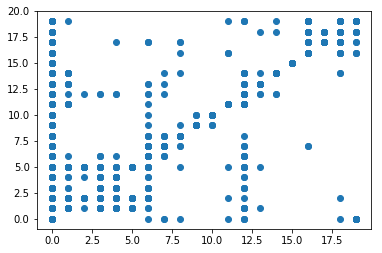

In [39]:
plt.scatter(y_test_pred_me, y_test_pred_naive)
plt.show()

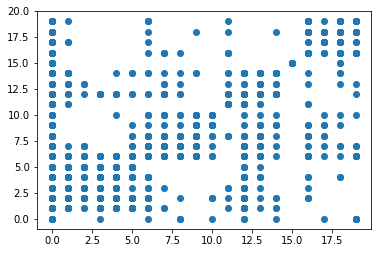

In [36]:
plt.scatter(y_train_pred_me, y_train_pred_naive)
plt.show()

## Comparing predicted values of Training data of two different classifier

In [37]:
print(classification_report(y_train_pred_me, y_train_pred_naive))

             precision    recall  f1-score   support

          0       0.98      0.22      0.36      3296
          1       0.83      0.82      0.82       770
          2       0.62      0.92      0.74       440
          3       0.81      0.83      0.82       796
          4       0.84      0.90      0.87       760
          5       0.81      0.87      0.84       624
          6       0.86      0.94      0.89       806
          7       0.81      0.94      0.87       684
          8       0.85      0.96      0.90       666
          9       0.80      0.93      0.86       632
         10       0.83      0.96      0.89       656
         11       0.68      0.96      0.80       515
         12       0.84      0.87      0.85       746
         13       0.77      0.91      0.84       596
         14       0.77      0.96      0.86       589
         15       0.67      1.00      0.80       528
         16       0.61      0.88      0.72       563
         17       0.55      0.93      0.69   

## Comparing predicted values of Testing data of two different classifier

In [38]:
print(classification_report(y_test_pred_me, y_test_pred_naive))

             precision    recall  f1-score   support

          0       0.98      0.22      0.37      1108
          1       0.78      0.73      0.75       260
          2       0.59      0.91      0.72       140
          3       0.79      0.85      0.82       263
          4       0.80      0.91      0.85       268
          5       0.77      0.82      0.79       222
          6       0.83      0.93      0.87       273
          7       0.74      0.90      0.81       187
          8       0.85      0.97      0.91       274
          9       0.83      0.92      0.87       215
         10       0.84      0.93      0.88       214
         11       0.73      0.95      0.82       177
         12       0.81      0.80      0.80       254
         13       0.78      0.92      0.85       188
         14       0.70      0.93      0.80       180
         15       0.64      1.00      0.78       154
         16       0.66      0.87      0.75       208
         17       0.55      0.93      0.69   